# Potato Po-tah-to

<p>
Quality control is a process used to ensure that a product or service meets certain standards of quality. It involves a set of activities that are designed to identify and prevent defects in a product or service. Quality control can include inspections, testing, and reviews to ensure that the product or service meets customer requirements. The goal of quality control is to identify and address problems before they become larger issues that could negatively impact customer satisfaction or the bottom line. Implementing quality control processes can help organizations improve their products and services and increase customer satisfaction.
</p>

Quality control is critical in the supply chain as it helps to ensure that products or materials meet the required quality standards and customer expectations. Here are some of the key reasons why quality control is important in the supply chain:
<ul>
    <li>Product consistency</li>
    <li>Supply chain efficiency</li>
    <li>Brand reputation</li>
    <li>Regulatory compliance</li>
</ul>


<p>
The Dataset being used is from Frito-Lay, the producer of many popular chips such as Lays and Doritos. A lot of research is being done to improve the quality of the food. Frito-Lay is the subsidiary of Pepsico that makes globally famous potato chips. The chips get burnt during the manufacturing process. There is a minimum requirement for the amount of the burned or damaged part that can be on a chip.
</p> <br>
<img src="https://storage.googleapis.com/kaggle-datasets-images/1837571/2999426/5fc41a69ed339b8860cafeda4b44ee66/dataset-cover.png?t=2022-01-03-10-14-05">

<div class="alert alert-success" role="alert">
<p>
In this project, images of chips are classified into two classes to ensure control over quality of the chips. For this image binary classification task, following models have been created:
<ul>    
    <li>Custom CNN model</li>
    <li>Custom CNN model with Data Augmentation</li>
</ul>
</p>
</div>

# Setup

In [4]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam
    
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

from sklearn.metrics import classification_report, confusion_matrix

### Setting up Callbacks

In [5]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=0)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0, 
                              patience=3, 
                              verbose=1,
                              restore_best_weights=True)

# Loading the Images

In [6]:
MAIN_DIR = "/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset"
train_dir = MAIN_DIR + "/Train"
test_dir = MAIN_DIR + "/Test"

In [7]:
for dirpath, dirnames, filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

2 directories and 0 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset'
2 directories and 1 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Test'
0 directories and 101 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Test/Not Defective'
0 directories and 93 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Test/Defective'
2 directories and 1 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Train'
0 directories and 401 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Train/Non-Defective'
0 directories and 370 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Train/Defective'


In [8]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = IDG(rescale=1./255, validation_split=0.2)
test_datagen = IDG(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               subset="training",
                                               shuffle=True,
                                               seed=40)

valid_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               subset="validation",
                                               shuffle=True,
                                               seed=40)


test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               shuffle=False,
                                               seed=40)

Found 616 images belonging to 2 classes.
Found 153 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


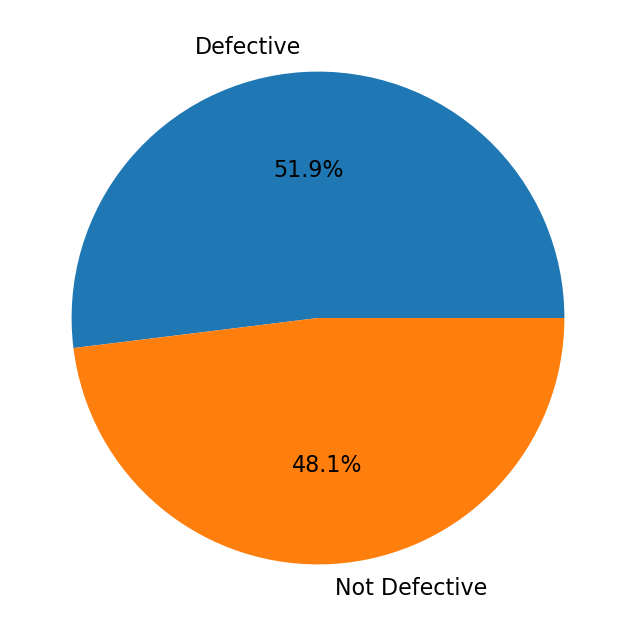

In [9]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(12,8))
labels = train_data.labels
vc = pd.Series(labels).value_counts()
plt.pie(vc, labels=['Defective', 'Not Defective'], autopct='%1.1f%%')
plt.show()

# Let's see some Chips

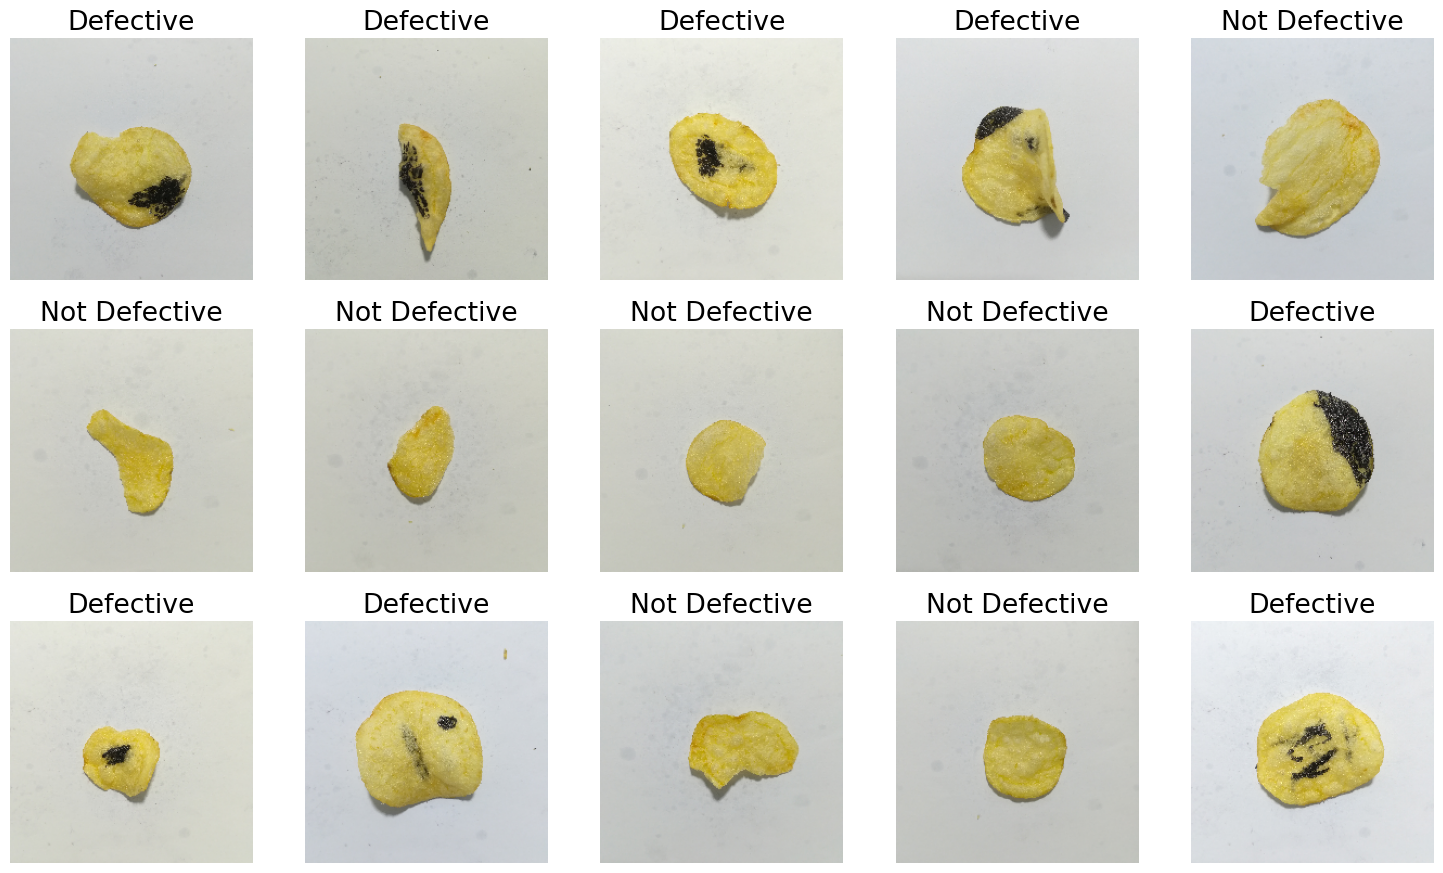

In [10]:
plt.figure(figsize=(15,9))

for i in range(15):
    axs = plt.subplot(3,5,i+1)
    x, y = train_data.next()
    plt.imshow(x[i])
    plt.axis('off')
    axs.set_title("Defective" if y[i] == 0 else "Not Defective")
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# Building the Model

For the Model building part, first approach is to begin with a small baseline model. Therefore, the first model will be a CNN trained from scratch

## Model 1

In [11]:
tf.random.set_seed(40)

model_1 = Sequential([
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_1.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy'])

history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data),
            callbacks=[checkpoint, earlystopping])

Epoch 1/5
20/20 [==============================] - 111s 5s/step - loss: 0.7522 - accuracy: 0.5016 - val_loss: 0.7038 - val_accuracy: 0.5229
Epoch 2/5
20/20 [==============================] - 96s 5s/step - loss: 0.6549 - accuracy: 0.6542 - val_loss: 0.5039 - val_accuracy: 0.9085
Epoch 3/5
20/20 [==============================] - 97s 5s/step - loss: 0.3481 - accuracy: 0.8620 - val_loss: 0.4211 - val_accuracy: 0.8170
Epoch 4/5
20/20 [==============================] - 97s 5s/step - loss: 0.1546 - accuracy: 0.9610 - val_loss: 0.0481 - val_accuracy: 0.9804
Epoch 5/5
20/20 [==============================] - 97s 5s/step - loss: 0.0615 - accuracy: 0.9789 - val_loss: 0.0354 - val_accuracy: 0.9935


In [12]:
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

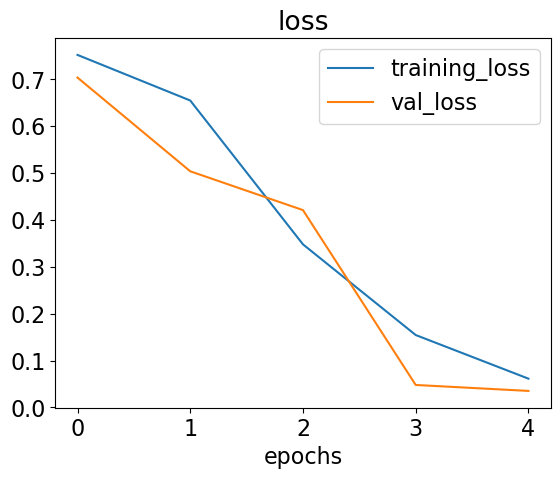

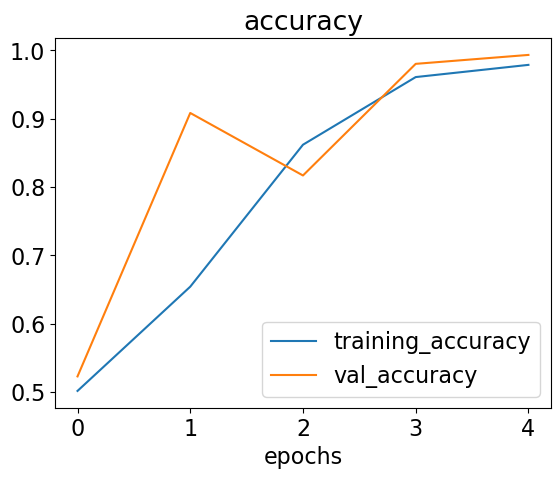

In [13]:
plot_curves(history_1)

In [14]:
result = model_1.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 97.92%
Loss: 0.0598


In [15]:
y_true = test_data.labels
y_pred = model_1.predict(test_data, verbose=0)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

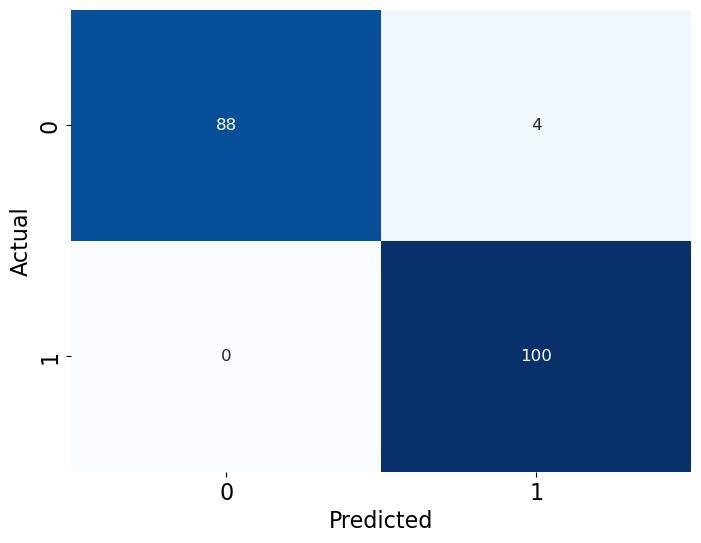

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true,y_pred), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The Model performs astonishingly well! But there is a catch. The images that are being used are very clear and the angles are fixed. But what if there were distortions in Real world scenarios? To ensure that the model is better prepared for such "edge" cases, **Data Augmentation** is introduced

# Data Augmentation

In [17]:
train_datagen_augmented = IDG(rescale=1/255.,
                              rotation_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              brightness_range=(0.8, 1.2),
                              width_shift_range=0.3,
                              height_shift_range=0.3,
                              horizontal_flip=True,
                              validation_split=0.2)

train_data_aug = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               subset="training",
                                               seed=40)

Found 616 images belonging to 2 classes.


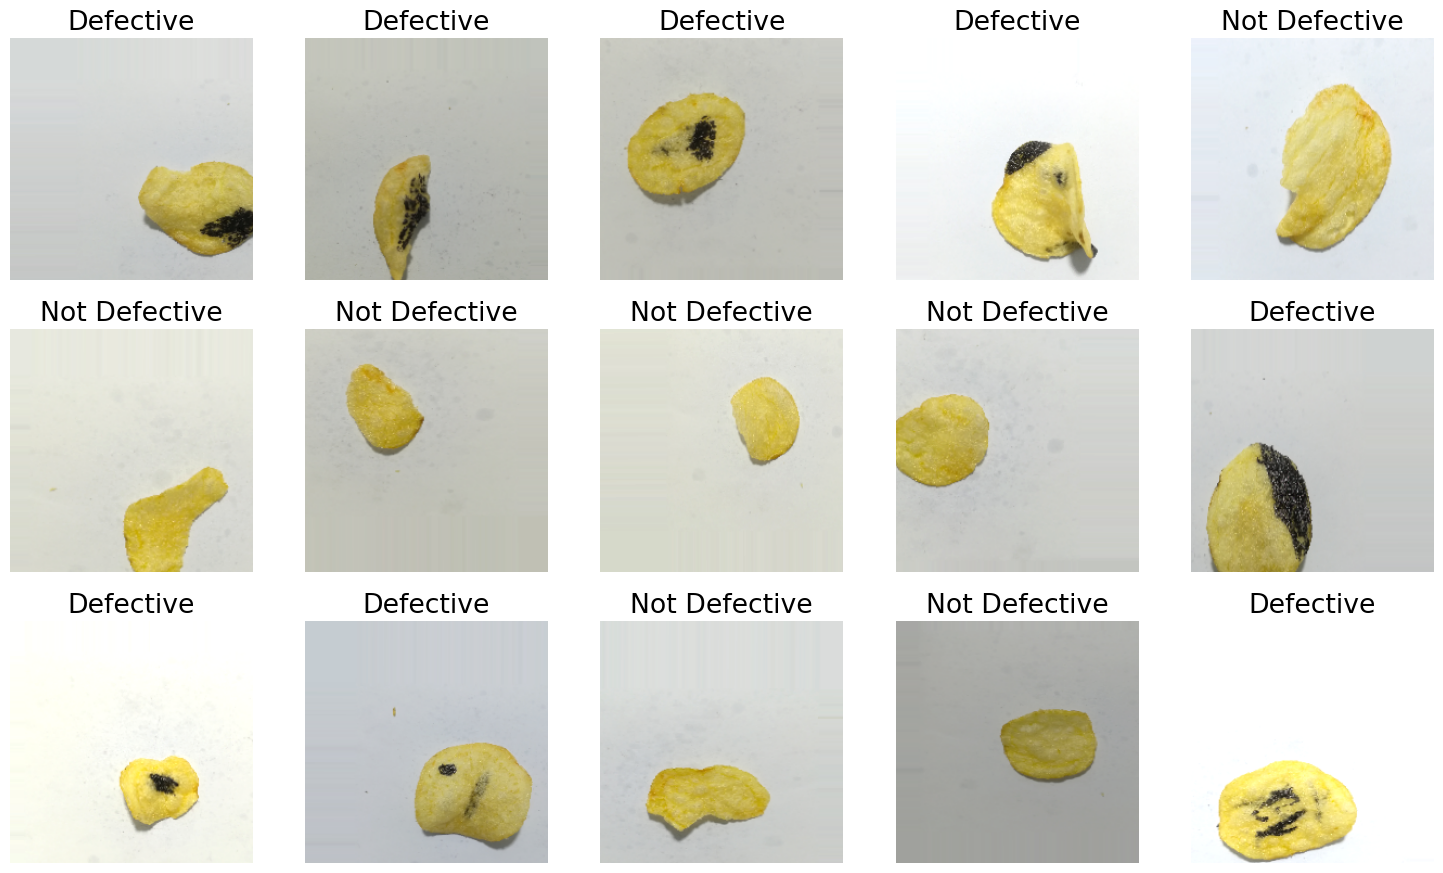

In [18]:
plt.figure(figsize=(15,9))

for i in range(15):
    axs = plt.subplot(3,5,i+1)
    x, y = train_data_aug.next()
    plt.imshow(x[i])
    plt.axis('off')
    axs.set_title("Defective" if y[i] == 0 else "Not Defective")
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

## Model 2

In [19]:
tf.random.set_seed(40)

model_2 = Sequential([
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_2.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

history_2 = model_2.fit(train_data_aug,
            epochs=5,
            steps_per_epoch=len(train_data_aug),
            validation_data=valid_data,
            validation_steps=len(valid_data),
            callbacks=[checkpoint, earlystopping])

Epoch 1/5
20/20 [==============================] - 107s 5s/step - loss: 0.7070 - accuracy: 0.4951 - val_loss: 0.6923 - val_accuracy: 0.5229
Epoch 2/5
20/20 [==============================] - 103s 5s/step - loss: 0.6942 - accuracy: 0.5227 - val_loss: 0.6933 - val_accuracy: 0.4706
Epoch 3/5
20/20 [==============================] - 104s 5s/step - loss: 0.6933 - accuracy: 0.5244 - val_loss: 0.6929 - val_accuracy: 0.5229
Epoch 4/5
20/20 [==============================] - 104s 5s/step - loss: 0.6930 - accuracy: 0.5195 - val_loss: 0.6928 - val_accuracy: 0.5229
Epoch 4: early stopping


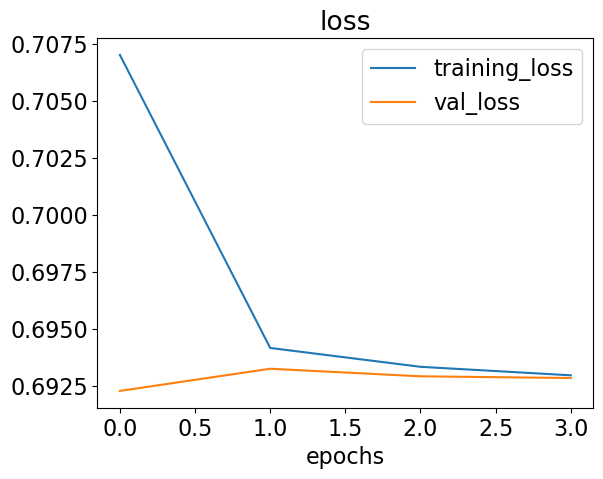

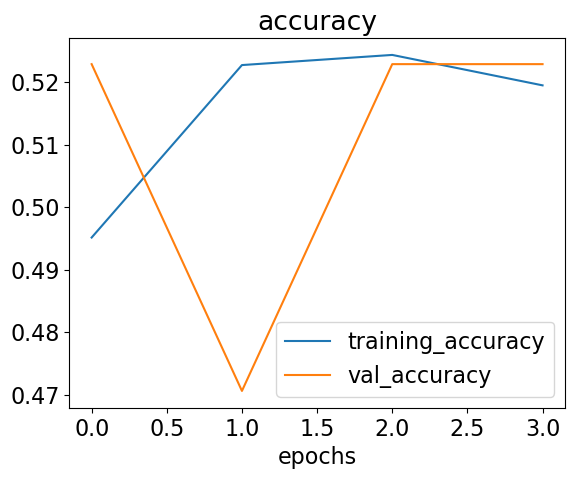

In [20]:
plot_curves(history_2)

In [21]:
result = model_2.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 52.08%
Loss: 0.6935


In [22]:
y_true = test_data.labels
y_pred = model_2.predict(test_data, verbose=0)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

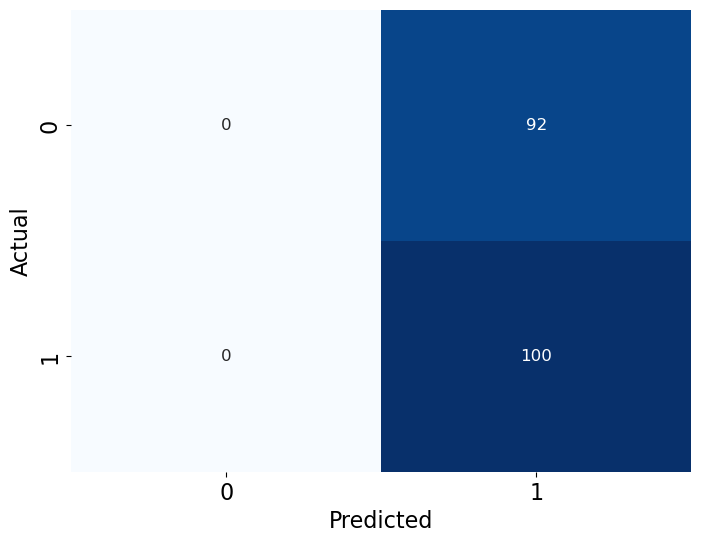

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true,y_pred), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Conclusion

Two models were trained for this classification task:
* Custom CNN model
* Custom CNN model with Data Augmentation

Both the models perform well, even when the images were heavily augmented. This indicates that the model will perform even when the input data is not absolutely clear. 

### Future Work

While this experiment demonstrates the task on Potato chips dataset, it could be applied to any manufacturing application. There are a lot of anomalies that occur during such activites that can lead to disrupted supply chain operations. The working of this model can be deployed to analyse and fix these issues. While it doesn't necessary help identify the root cause, this application can save up costs and brand reputation by ensuring quality product.

* This model can be deployed on an edge device, like JETSON NANO by Nvidia
* Develop a CAD model to segregate products